In [ ]:
!pip install torchaudio
import torchaudio

     |████████████████████████████████| 7.6MB 13.5MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [1]:
import numpy as np
import librosa
import torch

import IPython.display as ipd
import h5py
from sklearn.model_selection import train_test_split
import os
from os import listdir
from os.path import isfile, isdir, join
import random

In [ ]:
#audio feature extraction
noise_path = '/content/drive/Shareddrives/dsp final project/dataset/noise_train'
clean_path = '/content/drive/Shareddrives/dsp final project/dataset/clean_train'
noise = []
clean = []
for f in listdir(noise_path):
  noise.append(f)
#for f2 in listdir(clean_path):
#  clean.append(f2)

In [ ]:
X = []
y = []
lgth = 33000
for x in range(150):
  i = x+20000
  print("\r" + str(i) + " out of 23076", end="")
  noise_name = '/content/drive/Shareddrives/dsp final project/dataset/noise_train/'+noise[random.randint(0, 128)];
  clean_name = '/content/drive/Shareddrives/dsp final project/dataset/clean_train/'+clean[i]
  if noise_name.endswith('.wav') and clean_name.endswith('.wav'):
    y1,_ = librosa.load(noise_name,sr=16000)
    y2,_ = librosa.load(clean_name,sr=16000)
    rd = random.randint(0, int(y1.shape[0]/lgth)-1)
    if y2.shape[0]< lgth:
      continue
    y3 = (y1[lgth*rd:lgth*(rd+1)] + y2[:lgth])/2 #combine into mixed audio
    com_spec = librosa.stft(y3,n_fft = 512)#stft
    cle_spec = librosa.stft(y2[:lgth],n_fft = 512)
    X.append(np.expand_dims(com_spec[:,:257],axis = 0))#add channel and cut into multiple samples
    y.append(np.expand_dims(cle_spec[:,:257],axis = 0))
  else:
    continue

#X2 = torch.stack(X, 0)
#y2 = torch.stack(y, 0)
#print(X2.shape)

f = h5py.File("/content/drive/Shareddrives/dsp final project/test.hdf5", "w")
dsetx = f.create_dataset("X", data = np.array(X),chunks=True)
dsety = f.create_dataset("Y", data = np.array(y),chunks=True)
f.close()


20149 out of 23076

In [ ]:
#ipd.Audio(y1,rate=16000) 
#ipd.Audio(y2,rate=16000) 
#ipd.Audio(y3,rate=16000) 
noise_name = '/content/drive/Shareddrives/dsp final project/dataset/noise_train/'+noise[10];
y1,_ = librosa.load(noise_name,sr=16000)
ori = librosa.stft(y1,n_fft = 512)
inv_spec = librosa.istft(ori[:257,:257])
print(inv_spec.shape)

(32768,)


In [ ]:
#split data
from sklearn.model_selection import train_test_split
f = h5py.File("pre_data.hdf5", "r")
X_train, X_val, y_train, y_val = train_test_split(
    np.array(f["X"][:]), np.array(f["y"][:]), test_size=0.1, random_state=42)
f.close()
print("========")    
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print("========")
f2 = h5py.File("data.hdf5", "w")
dsetx_tr = f2.create_dataset("X_train", data = X_train,chunks=True)
dsety_tr = f2.create_dataset("y_train", data = y_train,chunks=True)
dsetx_va = f2.create_dataset("X_val", data = X_val,chunks=True)
dsety_va = f2.create_dataset("y_val", data = y_val,chunks=True)
f2.close()

In [2]:
#Network components
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [3]:
#Main network
""" Full assembly of the parts to form the complete network """
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
!pip install torch==1.4.0

     |████████████████████████████████| 753.4MB 23kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchaudio 0.7.2 has requirement torch==1.7.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1


In [ ]:
#Dataloader and training
from torch.optim import *
from torch.autograd import *
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
print("load f1")
f1 = h5py.File("/content/drive/Shareddrives/dsp final project/pre_data9.hdf5", "r")
print("load f2")
f2 = h5py.File("/content/drive/Shareddrives/dsp final project/pre_data9_val.hdf5", "r")
EPOCHS = 75
batch_size = 64
LEARNING_RATE = 0.001
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data.real
        self.y_data = y_data.real
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
## test data    
class testData(Dataset):
    
    def __init__(self, X_data, y_data, z_data):
        self.X_data = X_data.real
        self.y_data = y_data.real
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

""" 
X_train = f['X_train'][:]
X_val = f['X_val'][:]
X_test = f['X_test'][:]
maxt = np.amax(X_train)
mint = np.amin(X_train)
X_train_scaled = (X_train  - mint) / (maxt -mint)
X_val_scaled = (X_val - mint) / (maxt -mint)
X_test_scaled = (X_test  - mint) / (maxt -mint)
"""

"""
print("load dataset")
train_data = trainData(f['X_train'][:],f['y_train'][:],f['z_train'][:])
print("load dataset")
val_data = trainData(f['X_val'][:],f['y_val'][:],f['z_val'][:])
"""
train_data = trainData(f1['X'][:],f1['Y'][:])
val_data = trainData(f2['X'][:],f2['Y'][:])

print("dataloader")
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
#train
model = UNet(1,1).cuda()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
lr = LEARNING_RATE
print("train")
printout=""
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    va_loss = 0
    va_acc = 0
    
    #print(lr)
    #for g in optimizer.param_groups:
    #    g['lr'] = lr
    #lr -= 0.0009/75
    model.train()
    it = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        optimizer.zero_grad()
        #print(X_batch.shape,y_batch.shape, z_batch.shape)
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss.item())
        print("\r" + it + " out of " + str(len(train_loader)/64), end="")
        it += 1

    #model.eval()
    with torch.no_grad():
      for X_batch, y_batch,z_batch in val_loader:
          X_batch, y_batch,z_batch = X_batch.cuda(), y_batch.cuda()
          
          y_pred = model(X_batch)
          
          loss = criterion(y_pred, y_batch)
          #acc = mul_acc(y_pred, y_batch)
          
          va_loss += float(loss.item())   
    print(f'Train epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')
    print(f'Val epoch {e+0:03}: | Loss: {va_loss/len(val_loader):.5f}')
    #print(np.where(euc[-1]==euc[-1].max()))
torch.save(model, 'model.mdl')    


# monitor test loss and accuracy
test_loss = 0.
correct = 0.
total = 0.

model.eval()
for X_batch, y_batch,z_batch in test_loader:
    # move to GPU
    data, target,data2 = X_batch.cuda(), y_batch.cuda(),z_batch.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output,h_map  = model(data,data2)
    # calculate the loss
    loss = criterion(output, target)
    # update average test loss 
    test_loss += loss.data - test_loss
    # convert output probabilities to predicted class
    pred = output.data.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)
        
print('Test Loss: {:.6f}'.format(test_loss))

print('Test Accuracy: %2d%% (%2d/%2d)' % (
    100. * correct / total, correct, total))
print("test")        

load f1
load f2
dataloader
train


RuntimeError: ignored

In [35]:
import numpy as np
import h5py
import torch, os
from torch.optim import *
from torch.autograd import *
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

model_real = UNet(1,1,False).cuda()
model_imag = UNet(1,1,False).cuda()
model_real.load_state_dict(torch.load("/content/drive/Shareddrives/dsp final project/Unsound_model.mdl").state_dict())
model_imag.load_state_dict(torch.load("/content/drive/Shareddrives/dsp final project/Usound_model_imag.mdl").state_dict())

f = h5py.File("/content/drive/Shareddrives/dsp final project/test2.hdf5", "r")
Xr = torch.FloatTensor(f['X'][:].real).cuda()
Xi = torch.FloatTensor(f['X'][:].imag).cuda()
y = torch.FloatTensor(f['Y'][:])
print(Xr.size)
with torch.no_grad():
  y_real = model_real(Xr)
  y_imag = model_imag(Xi)


<built-in method size of Tensor object at 0x7f8b5acff1b0>


In [33]:
f = h5py.File("/content/drive/Shareddrives/dsp final project/test2.hdf5", "r")
print(f['X'].shape)
f.close()

In [36]:
conc = np.array([])
for i in range(2):
  input_spec = y_real[i][0] + y_imag[i][0]* 1.0j
  inv_spec = librosa.istft(input_spec.cpu().numpy()) 
  conc = np.concatenate((conc, inv_spec), axis=None)
librosa.output.write_wav('output.wav', conc, 16000)

In [37]:
ipd.Audio(conc,rate=16000) 

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


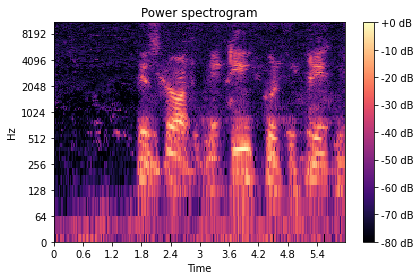

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(input_spec.cpu().numpy(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#output

In [ ]:
inv_spec = librosa.istft(input_spec.cpu().numpy())  

ipd.Audio(inv_spec,rate=16000) 


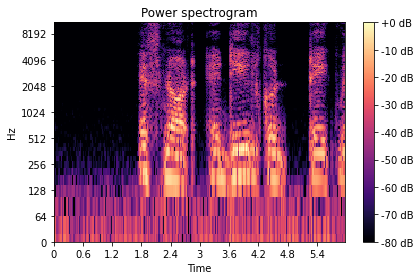

In [ ]:
inv_spec_y = librosa.istft(y[0][0].cpu().numpy())  

librosa.display.specshow(librosa.amplitude_to_db(y[0][0].cpu().numpy(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
#clean

In [ ]:
f = h5py.File("/content/drive/Shareddrives/dsp final project/test.hdf5", "r")
Xr = torch.FloatTensor(f['X'][:64].real).cuda()
Xi = torch.FloatTensor(f['X'][:64].imag).cuda()
Xout = Xr[0][0] + Xi[0][0]* 1.0j

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


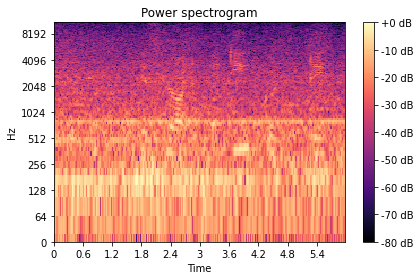

In [ ]:
inv_spec_y = librosa.istft(Xout.cpu().numpy())  
librosa.display.specshow(librosa.amplitude_to_db(Xout.cpu().numpy(),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ipd.Audio(inv_spec_y,rate=16000) 

Below is the testing section.

In [ ]:
#audio processing test
test_filepath = '/content/drive/MyDrive/ripped/Nu metal/Toxicity/06 Chop Suey!.mp3'
y,sr = torchaudio.load(test_filepath)
print(y.shape)
spec = torch.stft(torch.mean(y,dim=0),n_fft = 2048,return_complex=True)
print(spec.shape)
inv_spec = torch.istft(spec[:,:1000],n_fft = 2048)
ipd.Audio(inv_spec,rate=sr) 

In [14]:
#audio feature extraction
noise_path = '/content/drive/Shareddrives/dsp final project/dataset/noise_train'
clean_path = '/content/drive/Shareddrives/dsp final project/dataset/clean_train'
noise = []
clean = []
for f in listdir(noise_path):
  noise.append(f)
for f2 in listdir(clean_path):
  clean.append(f2)

In [34]:
X = []
y = []
lgth = 33000
noise_name = '/content/drive/Shareddrives/dsp final project/dataset/noise_train/'+noise[random.randint(0, 128)];
clean_name = '/content/drive/Shareddrives/dsp final project/dataset/clean_train/'+clean[20006]
if noise_name.endswith('.wav') and clean_name.endswith('.wav'):
  y1,_ = librosa.load(noise_name,sr=16000)
  y2,_ = librosa.load(clean_name,sr=16000)
  rd = random.randint(0, int(y1.shape[0]/lgth)-1)

  y3 = (y1[:y2.shape[0]] + y2[:])/2 #combine into mixed audio
  com_spec = librosa.stft(y3,n_fft = 512)#stft
  cle_spec = librosa.stft(y2,n_fft = 512)
X.append(np.expand_dims(com_spec[:,:257],axis = 0))#add channel and cut into multiple samples
y.append(np.expand_dims(cle_spec[:,:257],axis = 0))
X.append(np.expand_dims(com_spec[:,257:257*2],axis = 0))#add channel and cut into multiple samples
y.append(np.expand_dims(cle_spec[:,257:257*2],axis = 0))


#X2 = torch.stack(X, 0)
#y2 = torch.stack(y, 0)
#print(X2.shape)

f = h5py.File("/content/drive/Shareddrives/dsp final project/test2.hdf5", "w")
dsetx = f.create_dataset("X", data = np.array(X),chunks=True)
dsety = f.create_dataset("Y", data = np.array(y),chunks=True)
f.close()


In [39]:
librosa.output.write_wav('original.wav', y2, 16000)
librosa.output.write_wav('mixed.wav', y3, 16000)

In [18]:
for i in range(300):
  clean_name = '/content/drive/Shareddrives/dsp final project/dataset/clean_train/'+clean[i+20000]
  y,_ = librosa.load(clean_name,sr=16000)
  print(y.shape)
  

(28467,)
(45136,)
(54916,)
(45429,)
(25209,)
(39264,)
(65848,)
(42560,)
(29545,)
(69262,)
(36000,)
(63505,)
(44161,)
(37128,)
(36868,)
(43338,)
(35101,)
(34128,)
(22966,)
(38340,)
(34263,)
(52480,)
(39019,)
(67630,)
(54066,)
(43840,)
(35641,)


KeyboardInterrupt: ignored

In [ ]:
x = torch.rand(1,513,513)
li = []
y = torch.rand(1,513,513)
li2 = []
for i in range(100):
  li.append(x)
  li2.append(y)

x2 = torch.stack(li, 0)
y2 = torch.stack(li2, 0)
f = h5py.File("pre_data.hdf5", "w")
dsetx = f.create_dataset("X", data = x2,chunks=True)
dsety = f.create_dataset("y", data = y2,chunks=True)
f.close()

In [ ]:
#split data
from sklearn.model_selection import train_test_split
f = h5py.File("pre_data.hdf5", "r")
X_train, X_val, y_train, y_val = train_test_split(
    np.array(f["X"][:]), np.array(f["y"][:]), test_size=0.1, random_state=42)
f.close()
print("========")    
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print("========")
f2 = h5py.File("data8.hdf5", "w")
dsetx_tr = f2.create_dataset("X_train", data = X_train,chunks=True)
dsety_tr = f2.create_dataset("y_train", data = y_train,chunks=True)
dsetx_va = f2.create_dataset("X_val", data = X_val,chunks=True)
dsety_va = f2.create_dataset("y_val", data = y_val,chunks=True)
f2.close()


(90, 1, 513, 513)
(90, 1, 513, 513)
(10, 1, 513, 513)
(10, 1, 513, 513)


In [ ]:
from torch.utils.data import Dataset, DataLoader
f = h5py.File("data8.hdf5", "r")
EPOCHS = 75
batch_size = 64
LEARNING_RATE = 0.001
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
## test data    
class testData(Dataset):
    
    def __init__(self, X_data, y_data, z_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

""" 
X_train = f['X_train'][:]
X_val = f['X_val'][:]
X_test = f['X_test'][:]
maxt = np.amax(X_train)
mint = np.amin(X_train)
X_train_scaled = (X_train  - mint) / (maxt -mint)
X_val_scaled = (X_val - mint) / (maxt -mint)
X_test_scaled = (X_test  - mint) / (maxt -mint)
"""
print("load dataset")
train_data = trainData(f['X_train'][:],f['y_train'][:])
print("load dataset")
val_data = trainData(f['X_val'][:],f['y_val'][:])
print("dataloader")
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)

for X_batch, y_batch in train_loader:
  print(X_batch.shape)
  print(y_batch.shape)       

In [ ]:
import torchsummary
md = UNet(1,1).cuda()
torchsummary.summary(md,(1,257,257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 257, 257]             640
       BatchNorm2d-2         [-1, 64, 257, 257]             128
              ReLU-3         [-1, 64, 257, 257]               0
            Conv2d-4         [-1, 64, 257, 257]          36,928
       BatchNorm2d-5         [-1, 64, 257, 257]             128
              ReLU-6         [-1, 64, 257, 257]               0
        DoubleConv-7         [-1, 64, 257, 257]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1